In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class_dir = '/Users/Bella/Desktop/info-3600/'
nt_dir = class_dir + 'novel-technologies/'

# Load psychiatric_diagnosis_processed.csv
dx_label_data = pd.read_csv(class_dir + 'psychiatric_diagnosis_processed.csv')

# Load heart rate data
fitbit_data_physical_daily = pd.read_csv(nt_dir + 'nt_y_fitb_act_d.csv')  # Fitbit — Physical Activity (Daily)

In [3]:
# Drop NaNs in label dataset
dx_label_data = dx_label_data.dropna()

# Merge diagnosis labels dataset with fitbit daily physical activity data by subject and event marker
all_data = dx_label_data.merge(fitbit_data_physical_daily, on=['src_subject_id', 'eventname'], how='inner')

# Number of subjects in each dataset
print(f'Number of subjects in dx label dataset: {dx_label_data['src_subject_id'].nunique()}')
print(f'Number of subjects in merged dx/fitbit dataset: {all_data['src_subject_id'].nunique()}')

Number of subjects in dx label dataset: 11860
Number of subjects in merged dx/fitbit dataset: 7981


In [4]:
all_data['eventname'].unique()

array(['baseline_year_1_arm_1', '2_year_follow_up_y_arm_1',
       '4_year_follow_up_y_arm_1'], dtype=object)

### Compare data distributions of fitbit data for +psych diagnosis and -psych diagnosis groups

In [5]:
# Create binary column for +/- any psychiatric diagnosis
all_data['any_dx'] = all_data.loc[:, 'parent_report_si_dx':'parent_report_sleep_dx'].max(axis=1)

In [6]:
# Create data subset including only year 2 events
yr2_data = all_data[all_data['eventname'] == '2_year_follow_up_y_arm_1']
print(yr2_data['src_subject_id'].nunique())
yr2_data

7681


,src_subject_id,eventname,parent_report_si_dx,parent_report_sa_dx,parent_report_mood_dx,parent_report_psychotic_dx,parent_report_anxiety_dx,parent_report_elimination_dx,parent_report_eating_dx,parent_report_adhd_dx,...,fit_ss_fitbit_veryactivemin,fit_ss_fitbit_restingheartrate,fit_ss_mstep_lt_80_dailystep,fit_ss_dayt_total_steps,fit_ss_dayt_ave_met_value,fit_ss_dayt_sedentary_min,fit_ss_dayt_light_active_min,fit_ss_dayt_farily_active_min,fit_ss_dayt_very_active_min,any_dx
3203,NDAR_INV00CY2MDM,2_year_follow_up_y_arm_1,0,0,0,0,0,0,0,1,...,0.0,66.0,0,5553.0,1.83,536,292,0,0,1
3204,NDAR_INV00CY2MDM,2_year_follow_up_y_arm_1,0,0,0,0,0,0,0,1,...,15.0,70.0,0,8132.0,2.00,651,311,7,15,1
3205,NDAR_INV00CY2MDM,2_year_follow_up_y_arm_1,0,0,0,0,0,0,0,1,...,9.0,67.0,0,8266.0,1.97,636,319,8,9,1
3206,NDAR_INV00CY2MDM,2_year_follow_up_y_arm_1,0,0,0,0,0,0,0,1,...,0.0,66.0,0,4821.0,1.86,505,271,0,0,1
3207,NDAR_INV00CY2MDM,2_year_follow_up_y_arm_1,0,0,0,0,0,0,0,1,...,10.0,70.0,0,7248.0,1.94,505,249,20,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174431,NDAR_INVZZZP87KR,2_year_follow_up_y_arm_1,0,0,0,0,0,0,0,0,...,3.0,81.0,0,4819.0,1.93,380,184,17,3,0
174432,NDAR_INVZZZP87KR,2_year_follow_up_y_arm_1,0,0,0,0,0,0,0,0,...,0.0,79.0,0,2396.0,1.36,596,124,0,0,0
174433,NDAR_INVZZZP87KR,2_year_follow_up_y_arm_1,0,0,0,0,0,0,0,0,...,0.0,80.0,0,3145.0,1.34,681,126,0,0,0
174434,NDAR_INVZZZP87KR,2_year_follow_up_y_arm_1,0,0,0,0,0,0,0,0,...,15.0,79.0,0,6556.0,1.82,557,138,36,15,0


In [7]:
# Aggregate Fitbit measures by subject
fitbit_cols = [
    'fit_ss_fitbit_fairlyactivemin', 'fit_ss_fitbit_veryactivemin', 
    'fit_ss_fitbit_restingheartrate', 'fit_ss_mstep_lt_80_dailystep',
    'fit_ss_dayt_total_steps', 'fit_ss_dayt_ave_met_value', 
    'fit_ss_dayt_sedentary_min', 'fit_ss_dayt_light_active_min', 
    'fit_ss_dayt_farily_active_min', 'fit_ss_dayt_very_active_min'
]

In [8]:
# Identify columns that meet a threshold for acceptable missingness (set at 0.5 for now)
fitbit_cols_filtered = [col for col in fitbit_cols if yr2_data[col].isna().sum() / len(yr2_data) < 0.5]

# Drop rows with NaN in these filtered Fitbit columns only
yr2_data_filtered = yr2_data.dropna(subset=fitbit_cols_filtered)

# After dropping NaNs, how many subjects are left? Not too many dropped
print(yr2_data[fitbit_cols].isna().sum())
print(yr2_data['src_subject_id'].nunique())
print(yr2_data_filtered[fitbit_cols].isna().sum())
print(yr2_data_filtered['src_subject_id'].nunique())

fit_ss_fitbit_fairlyactivemin       440
fit_ss_fitbit_veryactivemin         440
fit_ss_fitbit_restingheartrate    14649
fit_ss_mstep_lt_80_dailystep          0
fit_ss_dayt_total_steps              29
fit_ss_dayt_ave_met_value            29
fit_ss_dayt_sedentary_min             0
fit_ss_dayt_light_active_min          0
fit_ss_dayt_farily_active_min         0
fit_ss_dayt_very_active_min           0
dtype: int64
7681
fit_ss_fitbit_fairlyactivemin     0
fit_ss_fitbit_veryactivemin       0
fit_ss_fitbit_restingheartrate    0
fit_ss_mstep_lt_80_dailystep      0
fit_ss_dayt_total_steps           0
fit_ss_dayt_ave_met_value         0
fit_ss_dayt_sedentary_min         0
fit_ss_dayt_light_active_min      0
fit_ss_dayt_farily_active_min     0
fit_ss_dayt_very_active_min       0
dtype: int64
7524


In [9]:
# Separate groups by psychiatric history (0=None, 1=Yes)
psych_dx_data = yr2_data_filtered[yr2_data_filtered['any_dx'] == 1]
anxiety_dx_data = psych_dx_data[psych_dx_data['parent_report_anxiety_dx'] == 1]
no_psych_dx_data = yr2_data_filtered[yr2_data_filtered['any_dx'] == 0]
print(psych_dx_data['src_subject_id'].nunique())  # Number of subjects with any psychiatric diagnosis
print(anxiety_dx_data['src_subject_id'].nunique())  # Number of subjects with anxiety diagnosis
print(no_psych_dx_data['src_subject_id'].nunique())  # Number of subjects with no psychiatric diagnosis

4092
2611
3432


In [16]:
2611/4092

0.6380742913000977

Over half of the subjects with a psychiatric diagnosis are diagnosed with anxiety

In [44]:
# Descriptive stats for fitbit features
yr2_data_filtered[fitbit_cols_filtered].describe()

,fit_ss_fitbit_fairlyactivemin,fit_ss_fitbit_veryactivemin,fit_ss_fitbit_restingheartrate,fit_ss_mstep_lt_80_dailystep,fit_ss_dayt_total_steps,fit_ss_dayt_ave_met_value,fit_ss_dayt_sedentary_min,fit_ss_dayt_light_active_min,fit_ss_dayt_farily_active_min,fit_ss_dayt_very_active_min
count,156562.000000,156562.000000,156562.000000,156562.000000,156562.000000,156562.000000,156562.000000,156562.000000,156562.000000,156562.000000
mean,22.182490,9.365944,72.468025,0.024118,8253.937469,1.982347,517.406114,246.792018,21.987462,9.180331
std,31.691662,20.169317,8.294788,0.153417,5062.711331,0.443891,191.784086,107.312824,31.288116,19.822298
min,0.000000,0.000000,44.000000,0.000000,0.000000,0.770000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,67.000000,0.000000,4495.000000,1.680000,407.000000,177.000000,0.000000,0.000000
50%,10.000000,1.000000,72.000000,0.000000,7758.000000,1.940000,521.000000,250.000000,10.000000,0.000000
75%,32.000000,10.000000,78.000000,0.000000,11173.000000,2.240000,624.000000,319.000000,32.000000,10.000000
max,731.000000,721.000000,116.000000,1.000000,50741.000000,7.350000,1440.000000,1018.000000,606.000000,721.000000


fit_ss_fitbit_fairlyactivemin: U-statistic=3096379876.0, p-value=6.217846429276869e-12


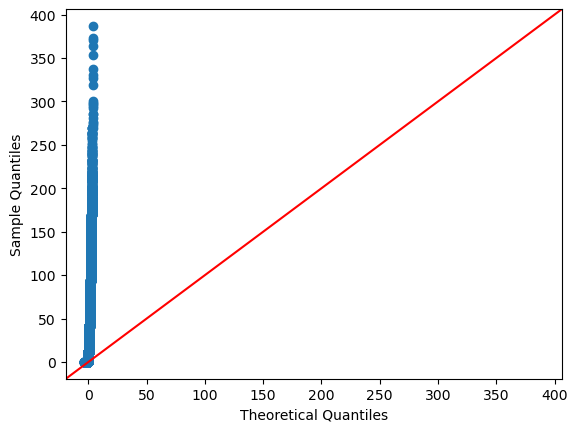

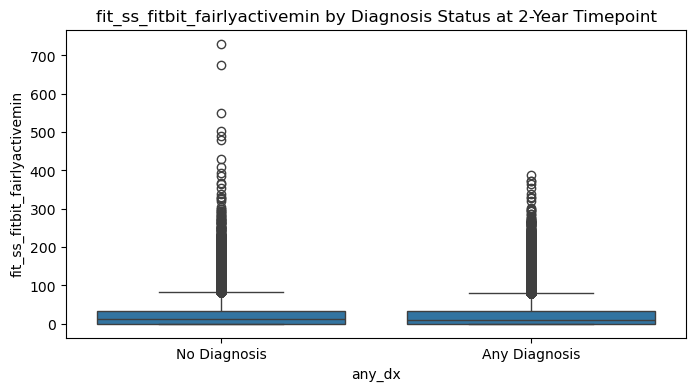

fit_ss_fitbit_veryactivemin: U-statistic=3080246427.5, p-value=2.1220855542632933e-07


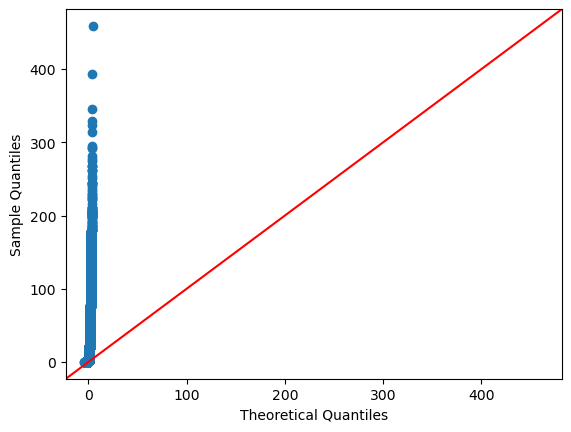

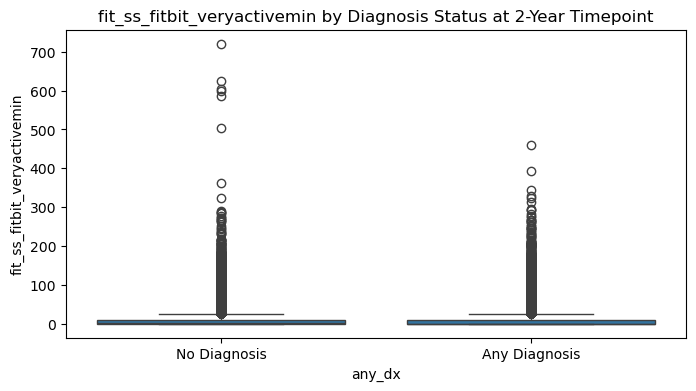

fit_ss_fitbit_restingheartrate: U-statistic=2926549398.0, p-value=2.0108424118784775e-35


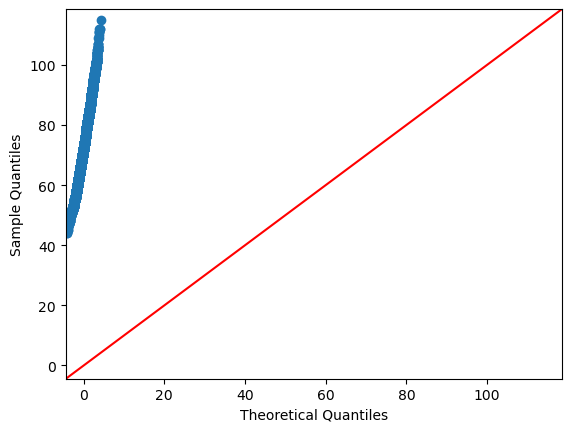

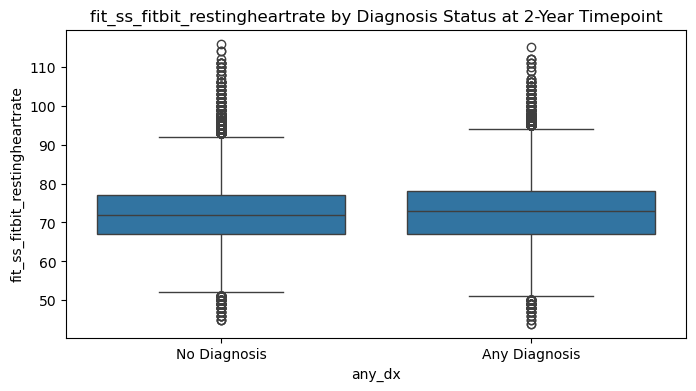

fit_ss_mstep_lt_80_dailystep: U-statistic=3036495696.5, p-value=0.8150494718960467


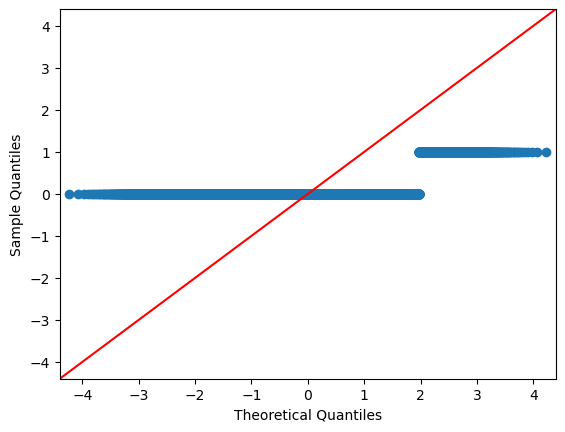

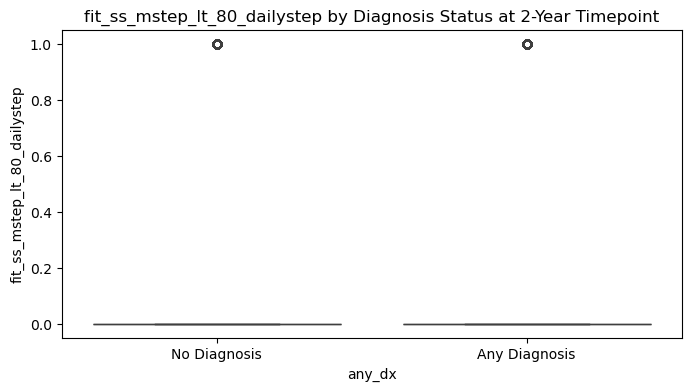

fit_ss_dayt_total_steps: U-statistic=3138110751.0, p-value=7.20528403649788e-30


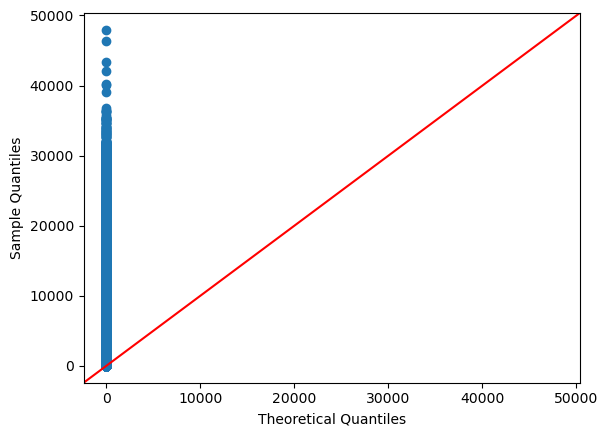

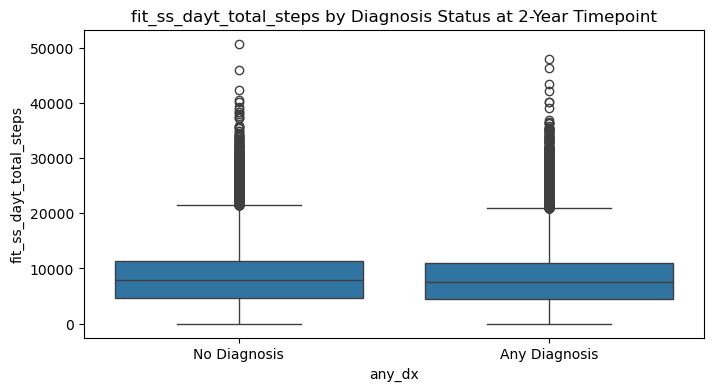

fit_ss_dayt_ave_met_value: U-statistic=3096986474.0, p-value=1.6607314548503056e-11


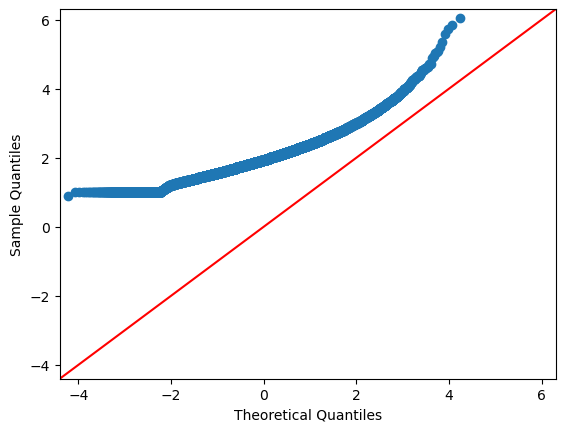

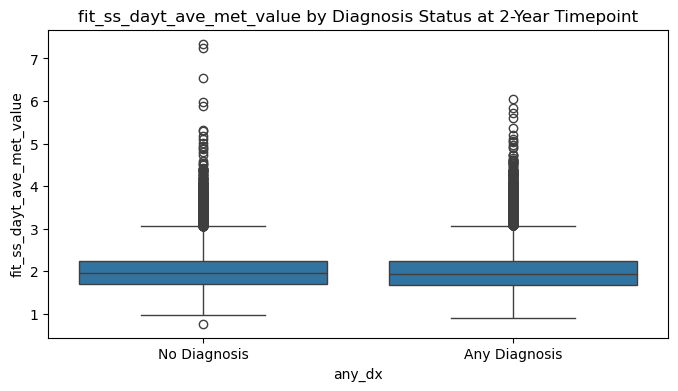

fit_ss_dayt_sedentary_min: U-statistic=3000049942.5, p-value=3.235776962335979e-05


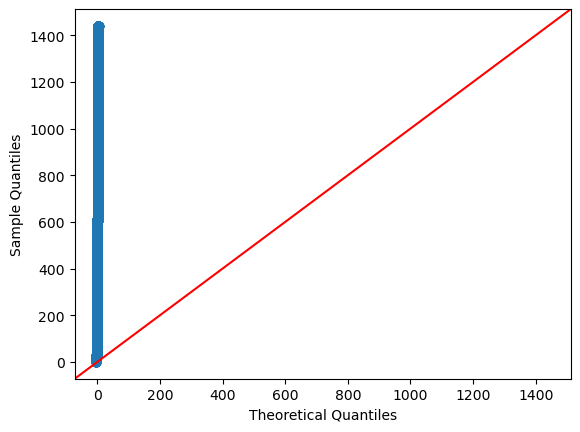

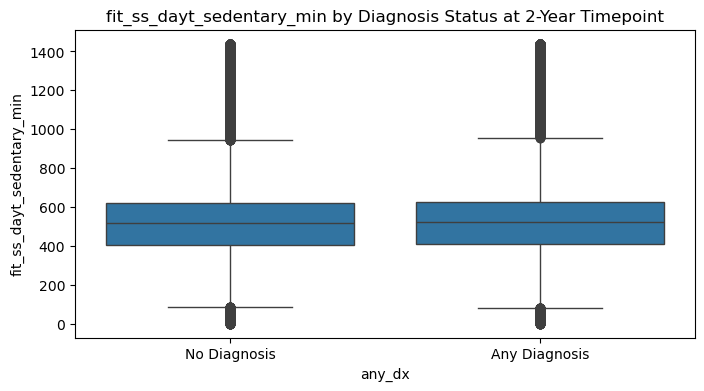

fit_ss_dayt_light_active_min: U-statistic=3102934016.0, p-value=1.3510126204198142e-13


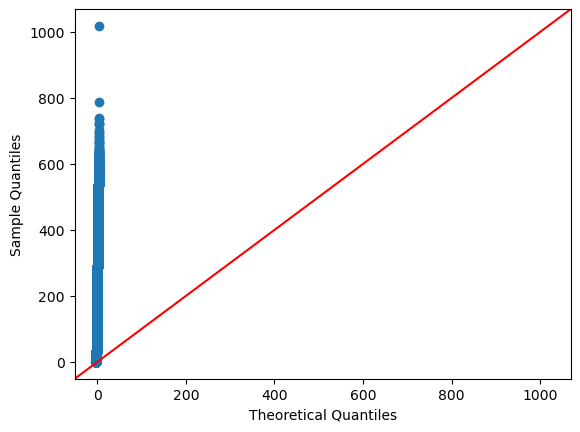

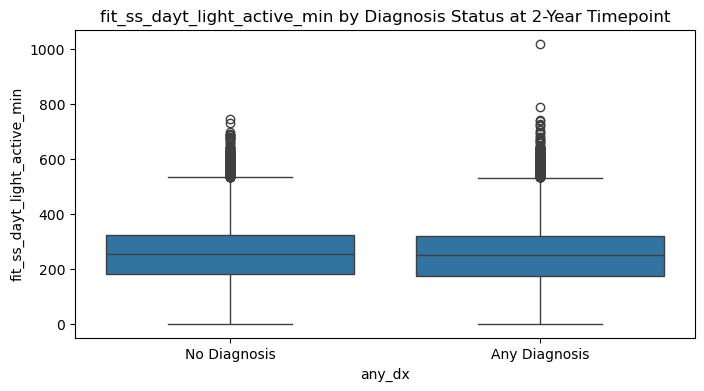

fit_ss_dayt_farily_active_min: U-statistic=3097001454.5, p-value=3.616168733803577e-12


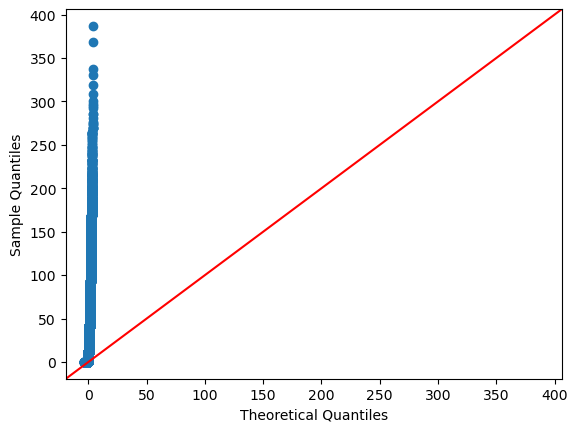

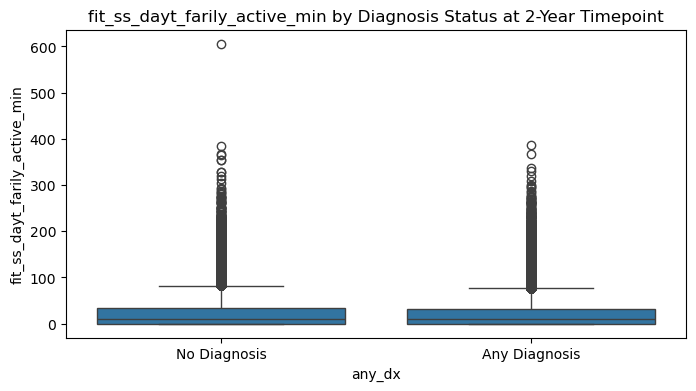

fit_ss_dayt_very_active_min: U-statistic=3082718594.5, p-value=3.9331541782867614e-08


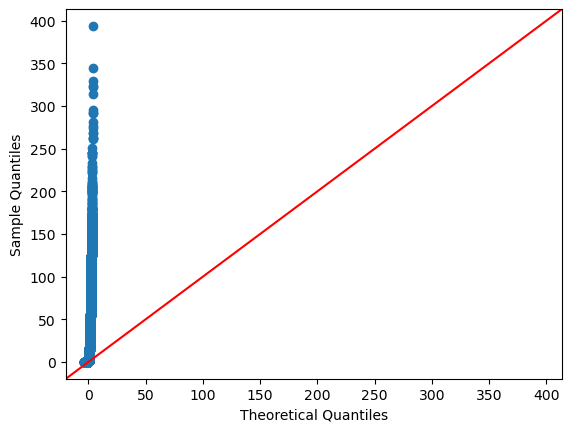

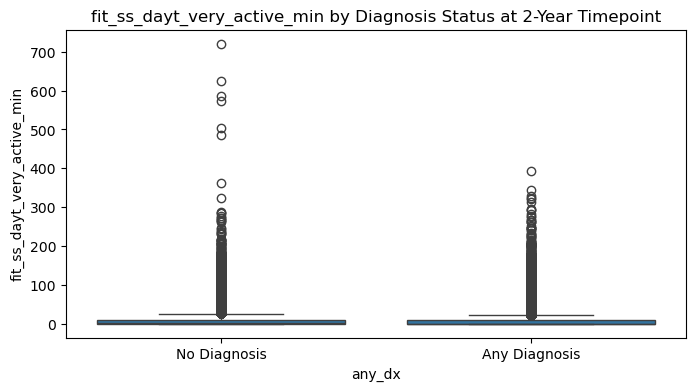

In [18]:
# Test for differences between psych diagnosis and no psych diagnosis groups
import statsmodels.api as sm

# Statistical testing and plotting of group differences
for col in fitbit_cols:
    stat, p_value = mannwhitneyu(no_psych_dx_data[col], psych_dx_data[col], alternative='two-sided')
    print(f"{col}: U-statistic={stat}, p-value={p_value}")
    
    # Assess normality for each variable distribution with q-q plot
    sm.qqplot(psych_dx_data[col], line='45')
    plt.show
    
    # Plot distributions
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=yr2_data_filtered, x='any_dx', y=col)
    plt.title(f'{col} by Diagnosis Status at 2-Year Timepoint')
    plt.xticks([0, 1], ['No Diagnosis', 'Any Diagnosis'])
    plt.ylabel(col)
    plt.show()

# Notes:
# Data severely non-normally distributed. Use non-parametric testing
# of these measures, only restingheartrate, dayt_total_steps, dayt_ave_met_value have a qqplot or box&whisker that suggests interesting variance in the data
# the other measures show stacked qq plots and almost flat b&w plots -- very low variability in the data, except large outliers

fit_ss_fitbit_fairlyactivemin: U-statistic=2021204645.0, p-value=1.7367250200353437e-32


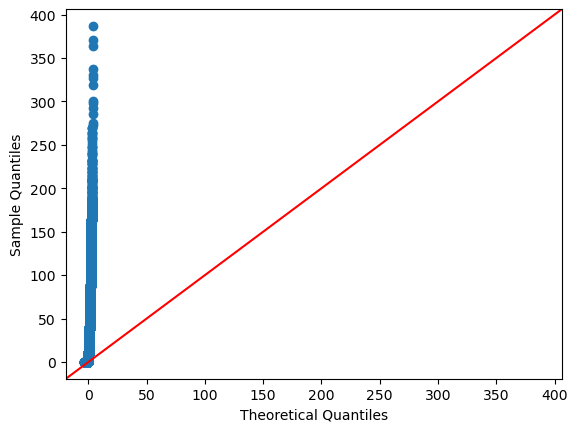

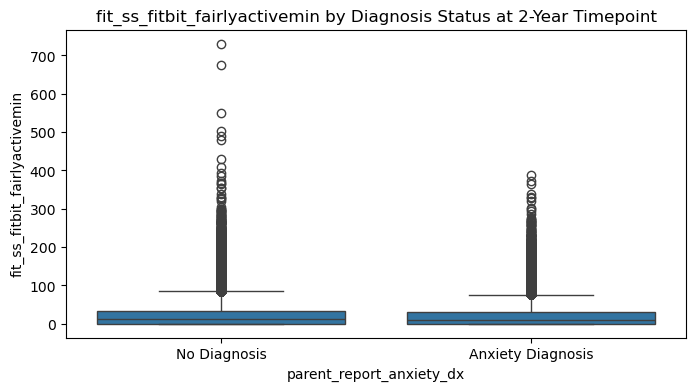

fit_ss_fitbit_veryactivemin: U-statistic=2010262572.5, p-value=1.0292430693305367e-25


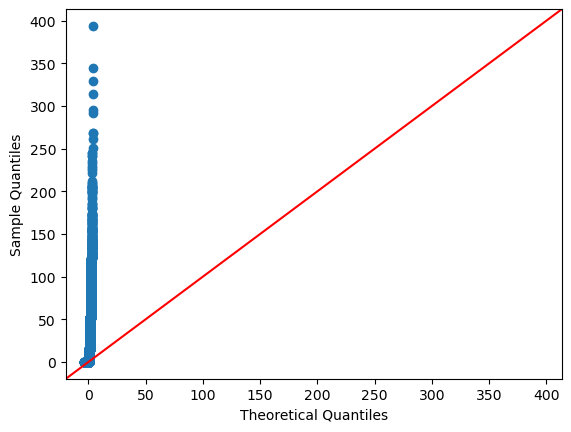

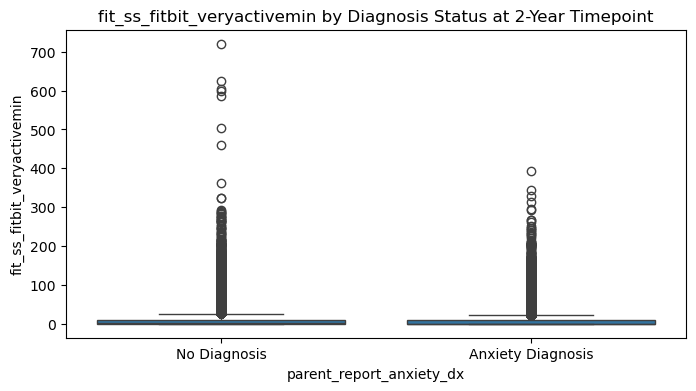

fit_ss_fitbit_restingheartrate: U-statistic=1828407903.5, p-value=7.220839945410638e-78


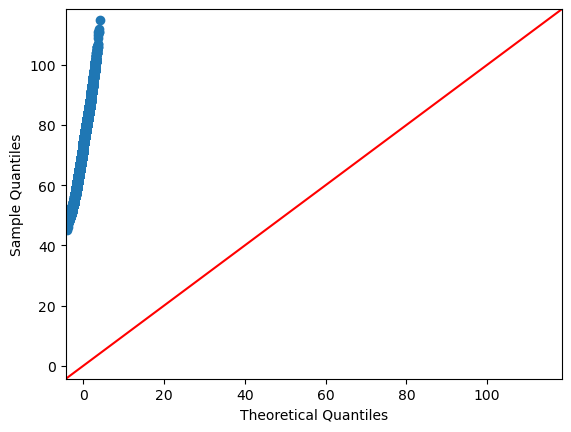

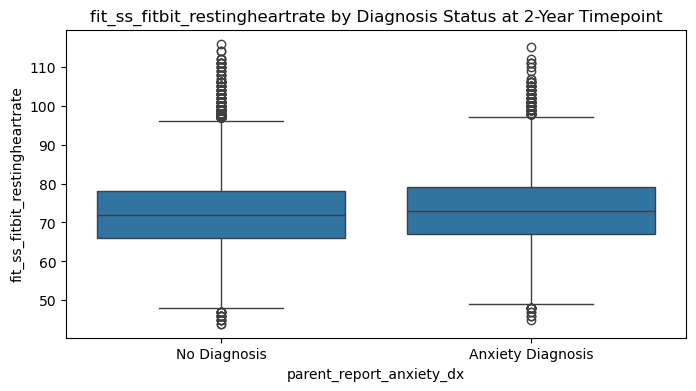

fit_ss_mstep_lt_80_dailystep: U-statistic=1951903173.5, p-value=0.011943019801509332


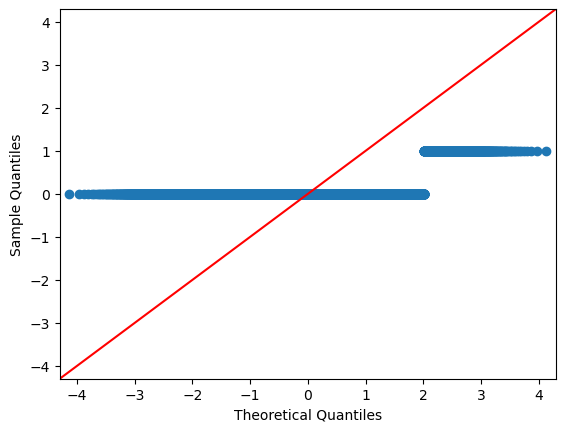

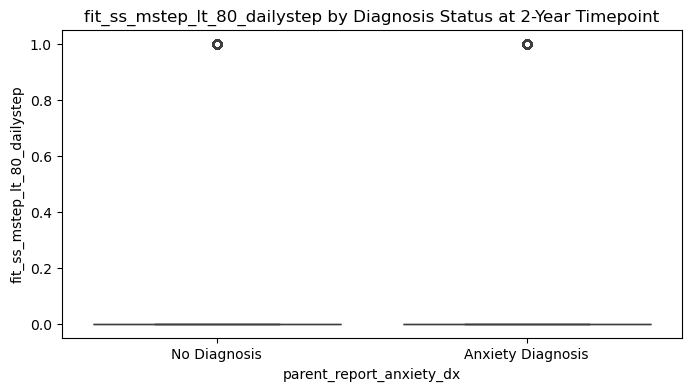

fit_ss_dayt_total_steps: U-statistic=2045054132.5, p-value=2.3262140940901784e-52


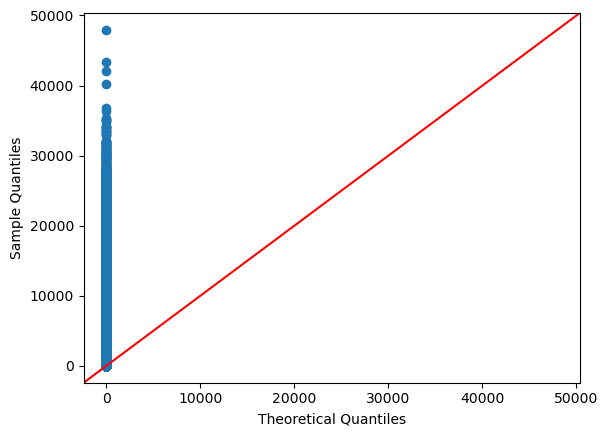

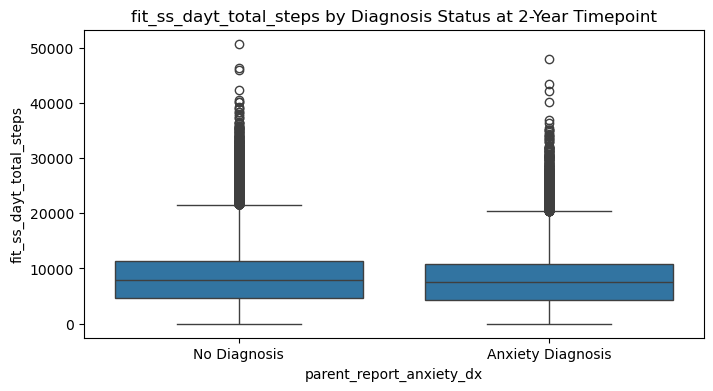

fit_ss_dayt_ave_met_value: U-statistic=2033628666.0, p-value=3.5121481043669535e-41


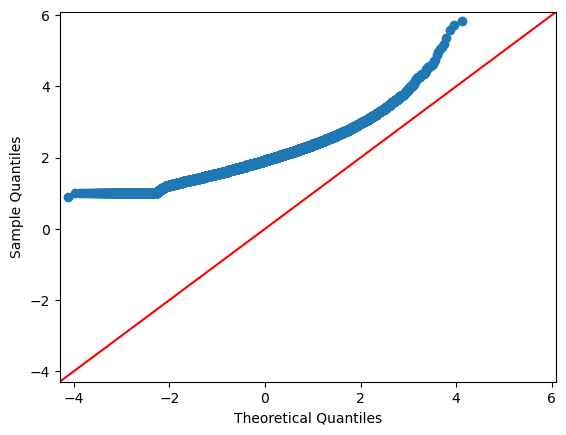

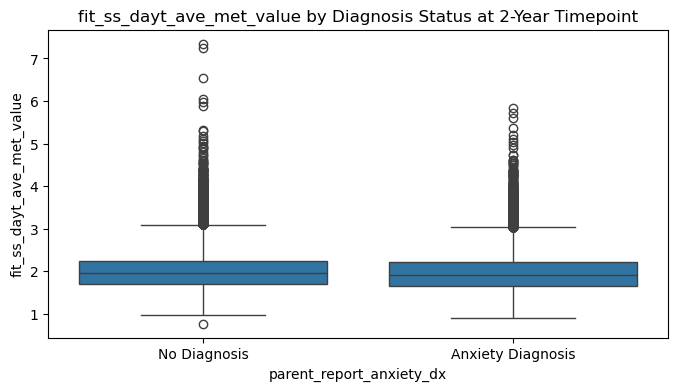

fit_ss_dayt_sedentary_min: U-statistic=1900742282.5, p-value=1.9768078416145454e-13


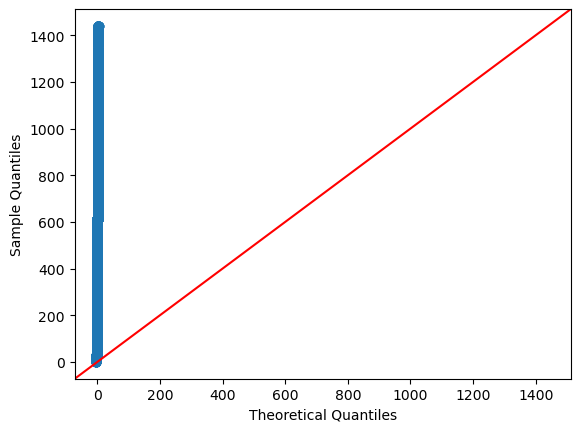

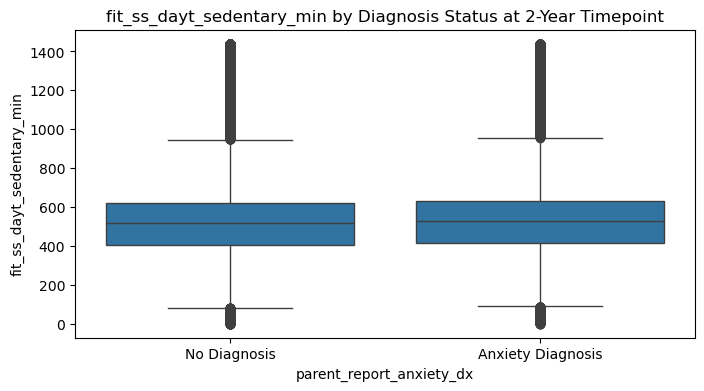

fit_ss_dayt_light_active_min: U-statistic=2002075927.0, p-value=1.8403008283466904e-17


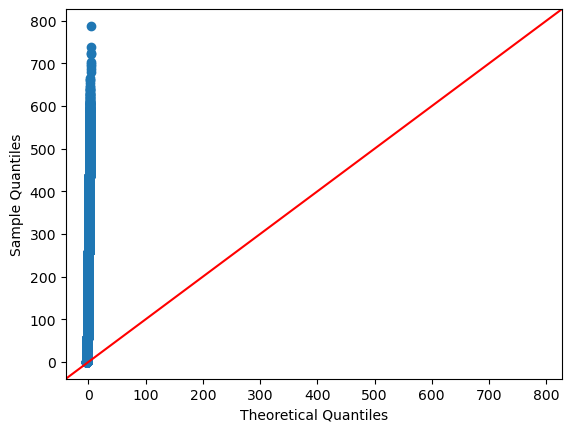

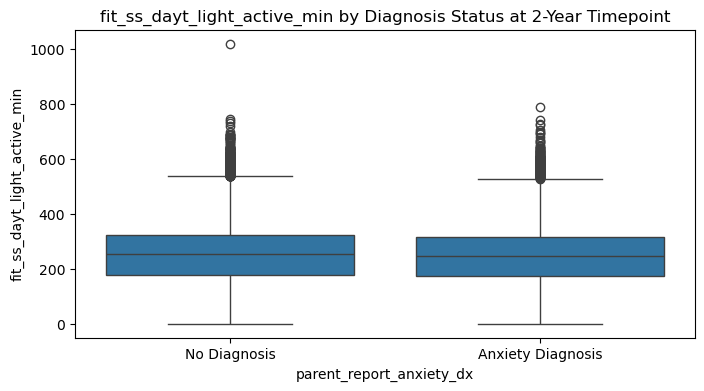

fit_ss_dayt_farily_active_min: U-statistic=2021796612.5, p-value=4.963097343945715e-33


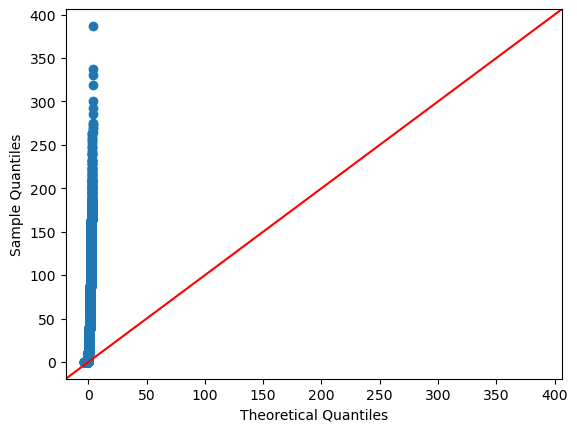

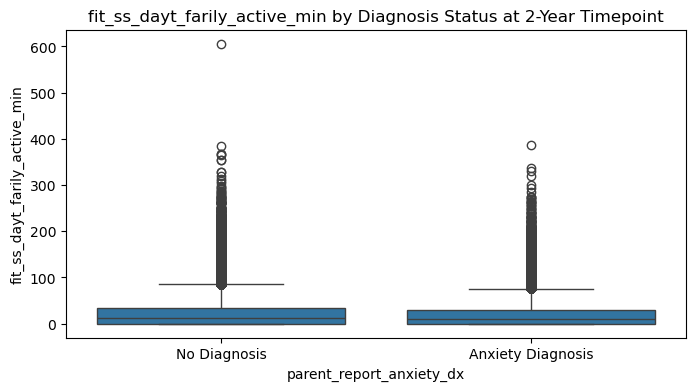

fit_ss_dayt_very_active_min: U-statistic=2012167027.0, p-value=2.767358019173654e-27


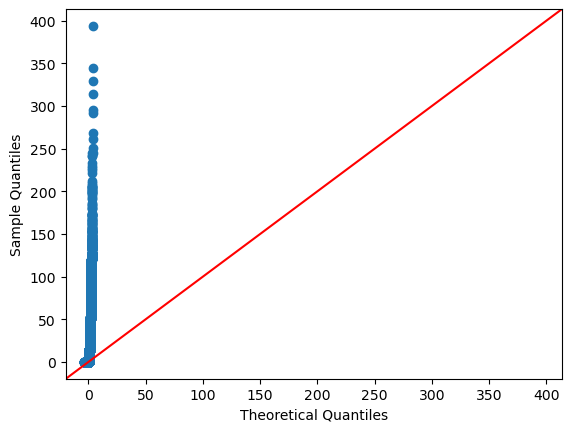

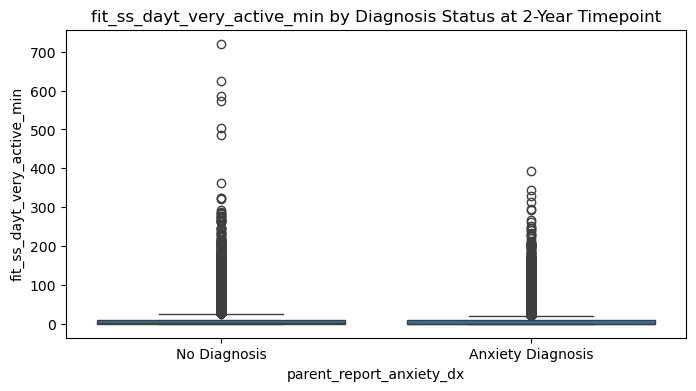

In [19]:
# Test for differences between anxiety and no psych diagnosis groups

import statsmodels.api as sm

# Statistical testing and plotting of group differences
for col in fitbit_cols:
    stat, p_value = mannwhitneyu(no_psych_dx_data[col], anxiety_dx_data[col], alternative='two-sided')
    print(f"{col}: U-statistic={stat}, p-value={p_value}")
    
    # Assess normality for each variable distribution with q-q plot
    sm.qqplot(anxiety_dx_data[col], line='45')
    plt.show
    
    # Plot distributions
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=yr2_data_filtered, x='parent_report_anxiety_dx', y=col)
    plt.title(f'{col} by Diagnosis Status at 2-Year Timepoint')
    plt.xticks([0, 1], ['No Diagnosis', 'Anxiety Diagnosis'])
    plt.ylabel(col)
    plt.show()

# Notes: